In [28]:
setwd("/home/pa/Documents/github/doc_suomi/code")
source("utils.R")
source("data_cook.R")
library("markovchain")
cat(howto_data)

`summarise()` has grouped output by 'album_id', 'name'. You can override using the `.groups` argument.



How to use datasets (Personal library)
 
call    base()             for real values
call    z_scored()         for normalized
call    min_maxed()        for normalized2
call    upsampled_album()  for binded upsamplped albums
call    low_minmax()       for min-maxed low level
call    low_z()            for normalized low level
call    low_raw()          for raw  low level

# Markov after comments
## States and transition probabilities

The transition matrices on the previous report were calculated with transitions between "Greater" and "Smaller" states, **but also from a null state**, which is the first track of the album. This is how I calculated the likelyhood of track 2 given track 1.

The final empirical transition matrices are displayed below, and it shows the probability of transition between a row to a column (e.g. prob of going from any state to the null state (i.e. start) is 0, because only the first track is in state "start").

In [17]:
dt = base() %>% 
        group_by(album_id) %>%
        mutate(valence = greater(valence),
               energy = greater(energy),
               loudness = greater(loudness),
               tempo = greater(tempo))

dt = album_splitter(dt)

# arr: array com transições; mo: empirically derived markov object, returns log likelihood of arr
ll = function(mo, arr){ t <- log(transitionProbability(mo, arr[1], arr[2]))
                        return( if( length(arr) == 2 ) t else t + ll(mo, arr[2:length(arr)]) )}

# get the mean likelihood of playlist
mll = function(mo, arr){ return (ll(mo, arr)/length(arr)) }

# split into traning and test data
dt_train  = dt[1:(length(dt)*0.8)]
dt_test   = dt[(length(dt)*0.8):length(dt)]

valence = c(); energy = c() ;loudness = c(); tempo = c()
rv = c(); re = c() ; rl = c(); rt = c()
valence_t = c(); energy_t = c() ;loudness_t = c(); tempo_t = c()

for(i in 1:length(dt_train)){
    valence[[i]]  <- c(as.character(dt_train[[i]]$valence))
    energy[[i]]   <- c(as.character(dt_train[[i]]$energy))
    loudness[[i]] <- c(as.character(dt_train[[i]]$loudness))
    tempo[[i]]    <- c(as.character(dt_train[[i]]$tempo))
}

for(i in 1:length(dt_train)){
    rv[[i]]  <- c("start", sample(as.character(dt_train[[i]]$valence[2:length(dt_train[[i]]$valence)]), replace = FALSE, size = length(dt_train[[i]]$valence)-1))
    re[[i]]   <- c("start", sample(as.character(dt_train[[i]]$energy[2:length(dt_train[[i]]$energy)]), replace = FALSE, size = length(dt_train[[i]]$energy)-1))
    rl[[i]] <- c("start", sample(as.character(dt_train[[i]]$loudness[2:length(dt_train[[i]]$loudness)]), replace = FALSE, size = length(dt_train[[i]]$loudness)-1))
    rt[[i]]    <- c("start", sample(as.character(dt_train[[i]]$tempo[2:length(dt_train[[i]]$tempo)]), replace = FALSE, size = length(dt_train[[i]]$tempo)-1))
}

for(i in 1:length(dt_test)){
    valence_t[[i]]  <- c(as.character(dt_test[[i]]$valence))
    energy_t[[i]]   <- c(as.character(dt_test[[i]]$energy))
    loudness_t[[i]] <- c(as.character(dt_test[[i]]$loudness))
    tempo_t[[i]]    <- c(as.character(dt_test[[i]]$tempo))
}

states = as.character(c("greater", "smaller", "start"))

# #Getting the transition
v = data.frame(markovchainFit(data = valence)$estimate@transitionMatrix)
e = data.frame(markovchainFit(data = energy)$estimate@transitionMatrix)
l = data.frame(markovchainFit(data = loudness)$estimate@transitionMatrix)
t = data.frame(markovchainFit(data = tempo)$estimate@transitionMatrix)

#creating the object
v <- new("markovchain", states = states, transitionMatrix = matrix(data = as.vector(t(v)), byrow = TRUE, nrow = nrow(v)), name = "valence")
e <- new("markovchain", states = states, transitionMatrix = matrix(data = as.vector(t(e)), byrow = TRUE, nrow = nrow(e)), name = "energy")
l <- new("markovchain", states = states, transitionMatrix = matrix(data = as.vector(t(l)), byrow = TRUE, nrow = nrow(l)), name = "loudness")
t <- new("markovchain", states = states, transitionMatrix = matrix(data = as.vector(t(t)), byrow = TRUE, nrow = nrow(t)), name = "tempo")

rv = data.frame(markovchainFit(data = rv)$estimate@transitionMatrix)
re = data.frame(markovchainFit(data = re)$estimate@transitionMatrix)
rl = data.frame(markovchainFit(data = rl)$estimate@transitionMatrix)
rt = data.frame(markovchainFit(data = rt)$estimate@transitionMatrix)

rv <- new("markovchain", states = states, transitionMatrix = matrix(data = as.vector(t(rv)), byrow = TRUE, nrow = nrow(v)), name = "rvalence")
re <- new("markovchain", states = states, transitionMatrix = matrix(data = as.vector(t(re)), byrow = TRUE, nrow = nrow(e)), name = "renergy")
rl <- new("markovchain", states = states, transitionMatrix = matrix(data = as.vector(t(rl)), byrow = TRUE, nrow = nrow(l)), name = "rloudness")
rt <- new("markovchain", states = states, transitionMatrix = matrix(data = as.vector(t(rt)), byrow = TRUE, nrow = nrow(t)), name = "rtempo")

for(j in 1){
    v_ll <- c(); e_ll <- c(); l_ll <- c(); t_ll <- c()
    
    r_v <- c(); r_e <- c(); r_l <- c(); r_t <- c()

    for(i in 1:length(valence_t)){
        v_ll[[i]] <- mll(v, valence_t[[i]])
        e_ll[[i]] <- mll(e, energy_t[[i]])
        l_ll[[i]] <- mll(l, loudness_t[[i]])
        t_ll[[i]] <- mll(t, tempo_t[[i]])
        
        r_v[[i]] <- mll(rv, valence_t[[i]])
        r_e[[i]] <- mll(re, energy_t[[i]])
        r_l[[i]] <- mll(rl, loudness_t[[i]])
        r_t[[i]] <- mll(rt, tempo_t[[i]])
        }
    }

log_likelihoods <- 
    data.frame(empirical_valence = unlist(v_ll),
               empirical_energy = unlist(e_ll),
               empirical_loudness = unlist(l_ll),
               empirical_tempo = unlist(t_ll),
               
               random_valence = unlist(r_v),
               random_energy = unlist(r_e),
               random_loudness = unlist(r_l),
               random_tempo = unlist(r_t)
              )

ll <-
    melt(data = log_likelihoods, 
        measure.vars = c('empirical_valence',
                         'empirical_energy',
                         'empirical_loudness',
                         'empirical_tempo',
                         'random_valence',
                         'random_energy',
                         'random_loudness',
                         'random_tempo')
    )

ll<- 
    tidyr::separate(ll, 
         variable, 
         c("condition", "feature"), 
         "_")

teste2 <- plyr::ddply(ll, c('feature', 'condition'), plyr::summarise,
                           log_likelihood = mean(value),
                           se = sd(value)/sqrt(length(value))
)
print("Valence"); v@transitionMatrix; 
print("Energy"); e@transitionMatrix; 
print("Loudness"); l@transitionMatrix; 
print("Tempo"); t@transitionMatrix

Warning message in melt(data = log_likelihoods, measure.vars = c("empirical_valence", :
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(log_likelihoods). In the next version, this warning will become an error.”


[1] "Valence"


,greater,smaller,start
greater,0.3205376,0.6794624,0
smaller,0.6677269,0.3322731,0
start,0.5336611,0.4663389,0


[1] "Energy"


,greater,smaller,start
greater,0.3118086,0.6881914,0
smaller,0.6616254,0.3383746,0
start,0.5075643,0.4924357,0


[1] "Loudness"


,greater,smaller,start
greater,0.3223561,0.6776439,0
smaller,0.6515744,0.3484256,0
start,0.5279879,0.4720121,0


[1] "Tempo"


,greater,smaller,start
greater,0.3328422,0.6671578,0
smaller,0.6619533,0.3380467,0
start,0.5075643,0.4924357,0


## State distributions

Here I computed the overal frequency of each state, State distribution seems to be stable accross different features, which strengthens the empirically derived transition matrices presented in section 1.1 (e.g. the transition between "smaller" to "smaller" in valence is not due to a generally low ammount of "smaller" states in the dataset - see frequency tables below)

In [18]:
dt = base() %>% 
        group_by(album_id) %>%
        mutate(valence = greater(valence),
               energy = greater(energy),
               loudness = greater(loudness),
               tempo = greater(tempo))

val = table(dt$valence)
en = table(dt$energy)
lou = table(dt$loudness)
temp = table(dt$loudness)

distr = data.table(
    valence = c(round(val[1]/(val[1]+val[2]+val[3]), 4), round(val[2]/(val[1]+val[2]+val[3]), 4), round(val[3]/(val[1]+val[2]+val[3]), 4)),
    energy = c(round(en[1]/(en[1]+en[2]+en[3]), 4), round(en[2]/(en[1]+en[2]+en[3]), 4), round(en[3]/(en[1]+en[2]+en[3]), 4)),
    loudnes = c(round(lou[1]/(lou[1]+lou[2]+lou[3]), 4), round(lou[2]/(lou[1]+lou[2]+lou[3]), 4), round(lou[3]/(lou[1]+lou[2]+lou[3]), 4)),
    tempo = c(round(temp[1]/(temp[1]+temp[2]+temp[3]), 4), round(temp[2]/(temp[1]+temp[2]+temp[3]), 4), round(temp[3]/(temp[1]+temp[2]+temp[3]), 4))
)

row.names(distr) <- c("Greater", "Smaller", "Start")
distr

,valence,energy,loudnes,tempo
,<dbl>,<dbl>,<dbl>,<dbl>
Greater,0.4551,0.4493,0.4495,0.4495
Smaller,0.4600,0.4658,0.4656,0.4656
Start,0.0849,0.0849,0.0849,0.0849


In [21]:
dt = base() %>% 
        group_by(album_id) %>%
        mutate(valence = greater(valence),
               energy = greater(energy),
               loudness = greater(loudness),
               tempo = greater(tempo))

dt = album_splitter(dt)

# arr: array com transições; mo: empirically derived markov object, returns log likelihood of arr
ll = function(mo, arr){ t <- log(transitionProbability(mo, arr[1], arr[2]))
                        return( if( length(arr) == 2 ) t else t + ll(mo, arr[2:length(arr)]) )}

# get the mean likelihood of playlist
mll = function(mo, arr){ return (ll(mo, arr)/length(arr)) }

# split into traning and test data
dt_train  = dt[1:(length(dt)*0.8)]
dt_test   = dt[(length(dt)*0.8):length(dt)]

valence = c(); energy = c() ;loudness = c(); tempo = c()
rv = c(); re = c() ; rl = c(); rt = c()
valence_t = c(); energy_t = c() ;loudness_t = c(); tempo_t = c()

for(i in 1:length(dt_train)){
    valence[[i]]  <- c(as.character(dt_train[[i]]$valence))
    energy[[i]]   <- c(as.character(dt_train[[i]]$energy))
    loudness[[i]] <- c(as.character(dt_train[[i]]$loudness))
    tempo[[i]]    <- c(as.character(dt_train[[i]]$tempo))
}

for(i in 1:length(dt_train)){
    rv[[i]]  <- c("start", sample(as.character(dt_train[[i]]$valence[2:length(dt_train[[i]]$valence)]), replace = FALSE, size = length(dt_train[[i]]$valence)-1))
    re[[i]]   <- c("start", sample(as.character(dt_train[[i]]$energy[2:length(dt_train[[i]]$energy)]), replace = FALSE, size = length(dt_train[[i]]$energy)-1))
    rl[[i]] <- c("start", sample(as.character(dt_train[[i]]$loudness[2:length(dt_train[[i]]$loudness)]), replace = FALSE, size = length(dt_train[[i]]$loudness)-1))
    rt[[i]]    <- c("start", sample(as.character(dt_train[[i]]$tempo[2:length(dt_train[[i]]$tempo)]), replace = FALSE, size = length(dt_train[[i]]$tempo)-1))
}

for(i in 1:length(dt_test)){
    valence_t[[i]]  <- c(as.character(dt_test[[i]]$valence))
    energy_t[[i]]   <- c(as.character(dt_test[[i]]$energy))
    loudness_t[[i]] <- c(as.character(dt_test[[i]]$loudness))
    tempo_t[[i]]    <- c(as.character(dt_test[[i]]$tempo))
}

states = as.character(c("greater", "smaller", "start"))

# #Getting the transition
v = data.frame(markovchainFit(data = valence)$estimate@transitionMatrix)
e = data.frame(markovchainFit(data = energy)$estimate@transitionMatrix)
l = data.frame(markovchainFit(data = loudness)$estimate@transitionMatrix)
t = data.frame(markovchainFit(data = tempo)$estimate@transitionMatrix)

#creating the object
v <- new("markovchain", states = states, transitionMatrix = matrix(data = as.vector(t(v)), byrow = TRUE, nrow = nrow(v)), name = "valence")
e <- new("markovchain", states = states, transitionMatrix = matrix(data = as.vector(t(e)), byrow = TRUE, nrow = nrow(e)), name = "energy")
l <- new("markovchain", states = states, transitionMatrix = matrix(data = as.vector(t(l)), byrow = TRUE, nrow = nrow(l)), name = "loudness")
t <- new("markovchain", states = states, transitionMatrix = matrix(data = as.vector(t(t)), byrow = TRUE, nrow = nrow(t)), name = "tempo")

rv = data.frame(markovchainFit(data = rv)$estimate@transitionMatrix)
re = data.frame(markovchainFit(data = re)$estimate@transitionMatrix)
rl = data.frame(markovchainFit(data = rl)$estimate@transitionMatrix)
rt = data.frame(markovchainFit(data = rt)$estimate@transitionMatrix)

rv <- new("markovchain", states = states, transitionMatrix = matrix(data = as.vector(t(rv)), byrow = TRUE, nrow = nrow(v)), name = "rvalence")
re <- new("markovchain", states = states, transitionMatrix = matrix(data = as.vector(t(re)), byrow = TRUE, nrow = nrow(e)), name = "renergy")
rl <- new("markovchain", states = states, transitionMatrix = matrix(data = as.vector(t(rl)), byrow = TRUE, nrow = nrow(l)), name = "rloudness")
rt <- new("markovchain", states = states, transitionMatrix = matrix(data = as.vector(t(rt)), byrow = TRUE, nrow = nrow(t)), name = "rtempo")

for(j in 1){
    v_ll <- c(); e_ll <- c(); l_ll <- c(); t_ll <- c()
    
    r_v <- c(); r_e <- c(); r_l <- c(); r_t <- c()

    for(i in 1:length(valence_t)){
        v_ll[[i]] <- mll(v, valence_t[[i]])
        e_ll[[i]] <- mll(e, energy_t[[i]])
        l_ll[[i]] <- mll(l, loudness_t[[i]])
        t_ll[[i]] <- mll(t, tempo_t[[i]])
        
        r_v[[i]] <- mll(rv, valence_t[[i]])
        r_e[[i]] <- mll(re, energy_t[[i]])
        r_l[[i]] <- mll(rl, loudness_t[[i]])
        r_t[[i]] <- mll(rt, tempo_t[[i]])
        }
    }

log_likelihoods <- 
    data.frame(empirical_valence = unlist(v_ll),
               empirical_energy = unlist(e_ll),
               empirical_loudness = unlist(l_ll),
               empirical_tempo = unlist(t_ll),
               
               random_valence = unlist(r_v),
               random_energy = unlist(r_e),
               random_loudness = unlist(r_l),
               random_tempo = unlist(r_t)
              )

ll <-
    melt(data = log_likelihoods, 
        measure.vars = c('empirical_valence',
                         'empirical_energy',
                         'empirical_loudness',
                         'empirical_tempo',
                         'random_valence',
                         'random_energy',
                         'random_loudness',
                         'random_tempo')
    )

ll<- 
    tidyr::separate(ll, 
         variable, 
         c("condition", "feature"), 
         "_")

teste2 <- plyr::ddply(ll, c('feature', 'condition'), plyr::summarise,
                           log_likelihood = mean(value),
                           se = sd(value)/sqrt(length(value))
)

Warning message in melt(data = log_likelihoods, measure.vars = c("empirical_valence", :
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(log_likelihoods). In the next version, this warning will become an error.”


In [22]:
# arr: array com transições; mo: empirically derived markov object, returns log likelihood of arr
ll = function(mo, arr){ t <- log(transitionProbability(mo, arr[1], arr[2]))
                        return( if( length(arr) == 2 ) t else t + ll(mo, arr[2:length(arr)]) )}

# get the mean likelihood of playlist
mll = function(mo, arr){ return (ll(mo, arr)/length(arr)) }

# Up-down by section (New report)

## Method 1

- Each album was divided into 3 sections;

- Within each section and each album, features received a tag of "greater" or "smaller".

- The tags "greater" or "smaller" related to the overall (mean) value of the feature within that album/track section.

- For instance, given album $A$, if the valence of track_1 was $10$, and the mean valence in position_1 was 15, the track received the tag "smaller". A few lines from the dataset are displayed below:

In [29]:
dt = base() %>% 
    mutate(position = segment(track_number)) %>%
    group_by(album_id, position) %>%
    mutate(overall_valence = mean(valence), 
           overall_energy = mean(energy), 
           overall_loudness = mean(loudness), 
           overall_tempo = mean(tempo))

dt %<>% 
    ungroup() %>%
    group_by(album_id) %>%
    mutate(valence_cat = greater_section(valence, overall_valence),
           energy_cat = greater_section(energy, overall_energy),
           loudness_cat = greater_section(loudness, overall_loudness),
           tempo_cat = greater_section(tempo, overall_tempo))

head(dt, 10) %>%
    ungroup() %>%
    select(track_number, position, valence, overall_valence, valence_cat)

track_number,position,valence,overall_valence,valence_cat
<int>,<chr>,<dbl>,<dbl>,<chr>
1,1st,0.0673,0.1645750,smaller
2,1st,0.2010,0.1645750,greater
3,1st,0.1770,0.1645750,greater
4,1st,0.2130,0.1645750,greater
5,2nd,0.5800,0.3900000,greater
6,2nd,0.5310,0.3900000,greater
7,2nd,0.2800,0.3900000,smaller
8,2nd,0.1690,0.3900000,smaller
9,3d,0.0816,0.1798667,smaller


## Method 2

Same thing as method 1, but colapsing each album in 4 sections.

In [24]:
dt = album_splitter(dt)

# split into traning and test data
dt_train  = dt[1:(length(dt)*0.8)]
dt_test   = dt[(length(dt)*0.8):length(dt)]

valence = c(); energy = c() ;loudness = c(); tempo = c()
rv = c(); re = c() ; rl = c(); rt = c()
valence_t = c(); energy_t = c() ;loudness_t = c(); tempo_t = c()

for(i in 1:length(dt_train)){
    valence[[i]]  <- c(as.character(dt_train[[i]]$valence_cat))
    energy[[i]]   <- c(as.character(dt_train[[i]]$energy_cat))
    loudness[[i]] <- c(as.character(dt_train[[i]]$loudness_cat))
    tempo[[i]]    <- c(as.character(dt_train[[i]]$tempo_cat))
}

for(i in 1:length(dt_train)){
    rv[[i]] <- c(sample(as.character(dt_train[[i]]$valence_cat), replace = FALSE, size = length(dt_train[[i]]$valence)))
    re[[i]] <- c(sample(as.character(dt_train[[i]]$energy_cat), replace = FALSE, size = length(dt_train[[i]]$energy)))
    rl[[i]] <- c(sample(as.character(dt_train[[i]]$loudness_cat), replace = FALSE, size = length(dt_train[[i]]$loudness)))
    rt[[i]] <- c(sample(as.character(dt_train[[i]]$tempo_cat), replace = FALSE, size = length(dt_train[[i]]$tempo)))
}

for(i in 1:length(dt_test)){
    valence_t[[i]]  <- c(as.character(dt_test[[i]]$valence_cat))
    energy_t[[i]]   <- c(as.character(dt_test[[i]]$energy_cat))
    loudness_t[[i]] <- c(as.character(dt_test[[i]]$loudness_cat))
    tempo_t[[i]]    <- c(as.character(dt_test[[i]]$tempo_cat))
}

states = as.character(c("greater", "smaller"))

# # #Getting the transition
v = data.frame(markovchainFit(data = valence)$estimate@transitionMatrix)
e = data.frame(markovchainFit(data = energy)$estimate@transitionMatrix)
l = data.frame(markovchainFit(data = loudness)$estimate@transitionMatrix)
t = data.frame(markovchainFit(data = tempo)$estimate@transitionMatrix)

# #creating the object
v <- new("markovchain", states = states, transitionMatrix = matrix(data = as.vector(t(v)), byrow = TRUE, nrow = nrow(v)), name = "valence")
e <- new("markovchain", states = states, transitionMatrix = matrix(data = as.vector(t(e)), byrow = TRUE, nrow = nrow(e)), name = "energy")
l <- new("markovchain", states = states, transitionMatrix = matrix(data = as.vector(t(l)), byrow = TRUE, nrow = nrow(l)), name = "loudness")
t <- new("markovchain", states = states, transitionMatrix = matrix(data = as.vector(t(t)), byrow = TRUE, nrow = nrow(t)), name = "tempo")

rv = data.frame(markovchainFit(data = rv)$estimate@transitionMatrix)
re = data.frame(markovchainFit(data = re)$estimate@transitionMatrix)
rl = data.frame(markovchainFit(data = rl)$estimate@transitionMatrix)
rt = data.frame(markovchainFit(data = rt)$estimate@transitionMatrix)

rv <- new("markovchain", states = states, transitionMatrix = matrix(data = as.vector(t(rv)), byrow = TRUE, nrow = nrow(v)), name = "rvalence")
re <- new("markovchain", states = states, transitionMatrix = matrix(data = as.vector(t(re)), byrow = TRUE, nrow = nrow(e)), name = "renergy")
rl <- new("markovchain", states = states, transitionMatrix = matrix(data = as.vector(t(rl)), byrow = TRUE, nrow = nrow(l)), name = "rloudness")
rt <- new("markovchain", states = states, transitionMatrix = matrix(data = as.vector(t(rt)), byrow = TRUE, nrow = nrow(t)), name = "rtempo")

for(j in 1){
    v_ll <- c(); e_ll <- c(); l_ll <- c(); t_ll <- c()
    
    r_v <- c(); r_e <- c(); r_l <- c(); r_t <- c()

    for(i in 1:length(valence_t)){
        v_ll[[i]] <- mll(v, valence_t[[i]])
        e_ll[[i]] <- mll(e, energy_t[[i]])
        l_ll[[i]] <- mll(l, loudness_t[[i]])
        t_ll[[i]] <- mll(t, tempo_t[[i]])
        
        r_v[[i]] <- mll(rv, valence_t[[i]])
        r_e[[i]] <- mll(re, energy_t[[i]])
        r_l[[i]] <- mll(rl, loudness_t[[i]])
        r_t[[i]] <- mll(rt, tempo_t[[i]])
        }
    }

log_likelihoods <- 
    data.frame(empirical_valence = unlist(v_ll),
               empirical_energy = unlist(e_ll),
               empirical_loudness = unlist(l_ll),
               empirical_tempo = unlist(t_ll),
               
               random_valence = unlist(r_v),
               random_energy = unlist(r_e),
               random_loudness = unlist(r_l),
               random_tempo = unlist(r_t)
              )

ll <-
    melt(data = log_likelihoods, 
        measure.vars = c('empirical_valence',
                         'empirical_energy',
                         'empirical_loudness',
                         'empirical_tempo',
                         'random_valence',
                         'random_energy',
                         'random_loudness',
                         'random_tempo')
    )

ll<- 
    tidyr::separate(ll, 
         variable, 
         c("condition", "feature"), 
         "_")

teste <- plyr::ddply(ll, c('feature', 'condition'), plyr::summarise,
                           log_likelihood = mean(value),
                           se = sd(value)/sqrt(length(value))
    )

Warning message in melt(data = log_likelihoods, measure.vars = c("empirical_valence", :
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(log_likelihoods). In the next version, this warning will become an error.”


In [25]:
#################################
##### Code of method 2 ##########
##### ###########################
dt = base() %>% 
    mutate(position = segment2(track_number)) %>%
    group_by(album_id, position) %>%
    mutate(overall_valence = mean(valence), 
           overall_energy = mean(energy), 
           overall_loudness = mean(loudness), 
           overall_tempo = mean(tempo))

# arr: array com transições; mo: empirically derived markov object, returns log likelihood of arr
ll = function(mo, arr){ t <- log(transitionProbability(mo, arr[1], arr[2]))
                        return( if( length(arr) == 2 ) t else t + ll(mo, arr[2:length(arr)]) )}

# get the mean likelihood of playlist
mll = function(mo, arr){ return (ll(mo, arr)/length(arr)) }

dt %<>% 
    ungroup() %>%
    group_by(album_id) %>%
    mutate(valence_cat = greater_section(valence, overall_valence),
           energy_cat = greater_section(energy, overall_energy),
           loudness_cat = greater_section(loudness, overall_loudness),
           tempo_cat = greater_section(tempo, overall_tempo))

valence = c(); energy = c() ;loudness = c(); tempo = c()
rv = c(); re = c() ; rl = c(); rt = c()
valence_t = c(); energy_t = c() ;loudness_t = c(); tempo_t = c()

# arr: array com transições; mo: empirically derived markov object, returns log likelihood of arr
ll = function(mo, arr){ t <- log(transitionProbability(mo, arr[1], arr[2]))
                        return( if( length(arr) == 2 ) t else t + ll(mo, arr[2:length(arr)]) )}

# get the mean likelihood of playlist
mll = function(mo, arr){ return (ll(mo, arr)/length(arr)) }

for(i in 1:length(dt_train)){
    valence[[i]]  <- c(as.character(dt_train[[i]]$valence_cat))
    energy[[i]]   <- c(as.character(dt_train[[i]]$energy_cat))
    loudness[[i]] <- c(as.character(dt_train[[i]]$loudness_cat))
    tempo[[i]]    <- c(as.character(dt_train[[i]]$tempo_cat))
}

for(i in 1:length(dt_train)){
    rv[[i]] <- c(sample(as.character(dt_train[[i]]$valence_cat), replace = FALSE, size = length(dt_train[[i]]$valence)))
    re[[i]] <- c(sample(as.character(dt_train[[i]]$energy_cat), replace = FALSE, size = length(dt_train[[i]]$energy)))
    rl[[i]] <- c(sample(as.character(dt_train[[i]]$loudness_cat), replace = FALSE, size = length(dt_train[[i]]$loudness)))
    rt[[i]] <- c(sample(as.character(dt_train[[i]]$tempo_cat), replace = FALSE, size = length(dt_train[[i]]$tempo)))
}

for(i in 1:length(dt_test)){
    valence_t[[i]]  <- c(as.character(dt_test[[i]]$valence_cat))
    energy_t[[i]]   <- c(as.character(dt_test[[i]]$energy_cat))
    loudness_t[[i]] <- c(as.character(dt_test[[i]]$loudness_cat))
    tempo_t[[i]]    <- c(as.character(dt_test[[i]]$tempo_cat))
}

states = as.character(c("greater", "smaller"))

# # #Getting the transition
v = data.frame(markovchainFit(data = valence)$estimate@transitionMatrix)
e = data.frame(markovchainFit(data = energy)$estimate@transitionMatrix)
l = data.frame(markovchainFit(data = loudness)$estimate@transitionMatrix)
t = data.frame(markovchainFit(data = tempo)$estimate@transitionMatrix)

# #creating the object
v <- new("markovchain", states = states, transitionMatrix = matrix(data = as.vector(t(v)), byrow = TRUE, nrow = nrow(v)), name = "valence")
e <- new("markovchain", states = states, transitionMatrix = matrix(data = as.vector(t(e)), byrow = TRUE, nrow = nrow(e)), name = "energy")
l <- new("markovchain", states = states, transitionMatrix = matrix(data = as.vector(t(l)), byrow = TRUE, nrow = nrow(l)), name = "loudness")
t <- new("markovchain", states = states, transitionMatrix = matrix(data = as.vector(t(t)), byrow = TRUE, nrow = nrow(t)), name = "tempo")

rv = data.frame(markovchainFit(data = rv)$estimate@transitionMatrix)
re = data.frame(markovchainFit(data = re)$estimate@transitionMatrix)
rl = data.frame(markovchainFit(data = rl)$estimate@transitionMatrix)
rt = data.frame(markovchainFit(data = rt)$estimate@transitionMatrix)

rv <- new("markovchain", states = states, transitionMatrix = matrix(data = as.vector(t(rv)), byrow = TRUE, nrow = nrow(v)), name = "rvalence")
re <- new("markovchain", states = states, transitionMatrix = matrix(data = as.vector(t(re)), byrow = TRUE, nrow = nrow(e)), name = "renergy")
rl <- new("markovchain", states = states, transitionMatrix = matrix(data = as.vector(t(rl)), byrow = TRUE, nrow = nrow(l)), name = "rloudness")
rt <- new("markovchain", states = states, transitionMatrix = matrix(data = as.vector(t(rt)), byrow = TRUE, nrow = nrow(t)), name = "rtempo")

for(j in 1){
    v_ll <- c(); e_ll <- c(); l_ll <- c(); t_ll <- c()
    
    r_v <- c(); r_e <- c(); r_l <- c(); r_t <- c()

    for(i in 1:length(valence_t)){
        v_ll[[i]] <- mll(v, valence_t[[i]])
        e_ll[[i]] <- mll(e, energy_t[[i]])
        l_ll[[i]] <- mll(l, loudness_t[[i]])
        t_ll[[i]] <- mll(t, tempo_t[[i]])
        
        r_v[[i]] <- mll(rv, valence_t[[i]])
        r_e[[i]] <- mll(re, energy_t[[i]])
        r_l[[i]] <- mll(rl, loudness_t[[i]])
        r_t[[i]] <- mll(rt, tempo_t[[i]])
        }
    }

log_likelihoods <- 
    data.frame(empirical_valence = unlist(v_ll),
               empirical_energy = unlist(e_ll),
               empirical_loudness = unlist(l_ll),
               empirical_tempo = unlist(t_ll),
               
               random_valence = unlist(r_v),
               random_energy = unlist(r_e),
               random_loudness = unlist(r_l),
               random_tempo = unlist(r_t)
              )

ll <-
    melt(data = log_likelihoods, 
        measure.vars = c('empirical_valence',
                         'empirical_energy',
                         'empirical_loudness',
                         'empirical_tempo',
                         'random_valence',
                         'random_energy',
                         'random_loudness',
                         'random_tempo')
    )

ll<- 
    tidyr::separate(ll, 
         variable, 
         c("condition", "feature"), 
         "_")

teste3 <- plyr::ddply(ll, c('feature', 'condition'), plyr::summarise,
                           log_likelihood = mean(value),
                           se = sd(value)/sqrt(length(value))
    )

Warning message in melt(data = log_likelihoods, measure.vars = c("empirical_valence", :
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(log_likelihoods). In the next version, this warning will become an error.”


In [26]:
teste2$method = "Original"
teste$method = "Method 1"
teste3$method = "Method 2"

teste1 = dplyr::bind_rows(teste2, teste, teste3)

## Evaluation

Here I'm comparing the difference in log-likelihood between the different methods of "feature tagging":

- Method 1: separating the album in 3 sections and comparing each track with the next section
- Method 2: separating the album in 4 sections and comparing each track with the next section
- Original: comparing each track with its nearest neighbors

Again, the statistics below show the likelyhood of the data given the transition matrices fitted on 1) the original dataset, and 2) a shuffled version of the same data set. I computed the mean log likelyhood for each album, and standard errors between them.

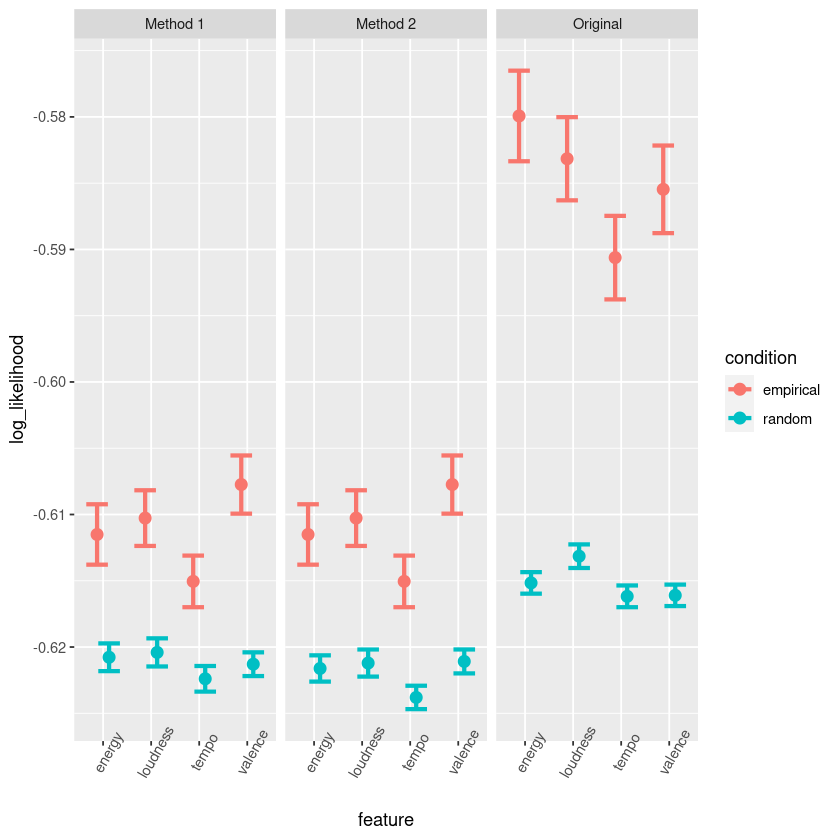

In [27]:
ggplot(teste1, aes(x=feature, y=log_likelihood, color = condition)) +
    facet_wrap(~method)+
    geom_errorbar(size = 1.2, aes(ymin=log_likelihood-se, ymax=log_likelihood+se), position=position_dodge(0.5)) +
    geom_point(size = 3, position=position_dodge(0.5), fill = 'black') +
    theme(axis.text.x = element_text(angle = 60))

It seems like the difference in likelyhood between the model fitted on the permutated dataset is largest when we use the 1st method. Perhaps we can try some different grouping methods.